# Smoothing binding sites predictions - model training

This part is dedicated to the training of binding sites smoothing. After getting the CryptoBench predictions, we cluster the residues using the DBScan algorithm to get the clusters. However, the predictions are not perfect - some residues are missing due to low prediction score. So, we train another model here that tries to solve this problem - this model tries to "smoothen" the predictions by including residues that are nearby.

To succesfully train the model, make sure that you have:
- `ESM_EMBEDDINGS_PATH` - a folder with precomputed `.npy` ESM-2 650M embeddings (you can use `https://github.com/skrhakv/esm2-generator/blob/master/compute-esm.py`)
- `DISTANCE_MATRICES_PATH` - a folder with precomputed `.npy` distance matrices (you can use the `compute_distance_matrix.py` script)
- `TRAIN_SET_PATH` - path to the `.csv` file containing the train set data (included here)
- `TEST_SET_PATH` - path to the `.csv` file containing the test set data (included here)

In [33]:
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset    
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.utils import class_weight
from sklearn import metrics

DATASET = 'cryptobench'
DATA_PATH = f'/home/polakluk/{DATASET}-data'

ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/650M-embeddings'
DISTANCE_MATRICES_PATH = f'{DATA_PATH}/distance-matrices'
TRAIN_SET_PATH = f'{DATA_PATH}/train.csv'
TEST_SET_PATH = f'{DATA_PATH}/test.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
POSITIVE_DISTANCE_THRESHOLD = 15
NEGATIVE_DISTANCE_THRESHOLD = 10

def process_sequence_dataset(annotation_path, embeddings_path, distance_matrices_path, perform_assertions=True):
    Xs = {}
    Ys = {}
    idx = {}

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            if perform_assertions:
                sequence = row[4]

            if row[3] == '':
                continue
            
            assert id not in Xs
            assert id not in Ys
            Xs[id] = []
            Ys[id] = []
            idx[id] = []

            filename = id + '.npy'
            embedding = np.load(f'{embeddings_path}/{filename}')
            
            distance_matrix = np.load(f'{distance_matrices_path}/{id}.npy')

            negative_examples_indices = set()
            binding_residues_indices = [int(residue[1:]) for residue in row[3].split(' ')]
            
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                if perform_assertions:
                    assert sequence[residue_idx] == aa
                # check if the distance of the residue to all other residues is less than the threshold
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                # get residues that are close to the current residue and are binding residues
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)
                
                # create embedding by aggregating the embeddings of the close binding residues
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(1) # positive example
                idx[id].append(residue_idx)
                
                # Let's get negative examples:
                # add those that are really close to the binding residues (i.e. within NEGATIVE_DISTANCE_THRESHOLD) but are not binding residues
                really_close_residues_indices = np.where(distance_matrix[residue_idx] < NEGATIVE_DISTANCE_THRESHOLD)[0]
                # add non-binding residues to the list of negatives (that's the exclusive left join of really_close_residues_indices and binding_residues_indices)
                negative_examples_indices.update(set(list(really_close_residues_indices)) - set(list(binding_residues_indices)))

            # add negative examples - create the embeddings 
            for residue_idx in negative_examples_indices:
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)

                # create embedding 
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(0) # negative example
                idx[id].append(residue_idx)

    return Xs, Ys, idx

class SmoothnessClassifierDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []

        for key, _ in _Xs.items():
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


In [35]:
Xs_train_apo, Ys_train_apo, _ = process_sequence_dataset(TRAIN_SET_PATH, ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
train_dataset_apo = SmoothnessClassifierDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo, idx_test_apo = process_sequence_dataset(TEST_SET_PATH, ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
test_dataset_apo = SmoothnessClassifierDataset(Xs_test_apo, Ys_test_apo)

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...


In [36]:
import os

DECISION_THRESHOLD = 0.8
DROPOUT = 0.3
LAYER_WIDTH = 256
ESM2_DIM  = 1280 * 2

class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)
        
def train(model, optimizer, epochs, batch_size, train_dataset, test_dataset):
    model = model.to(device)

    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=2 * class_weights[1])

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            
            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            test_pred = (torch.sigmoid(test_logits)>DECISION_THRESHOLD).float()

            # compute metrics
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
            fpr, tpr, _ = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)
            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
            precision, recall, _ = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits, y_batch)
            acc = accuracy_fn(y_true=y_batch, y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    os.makedirs('fig', exist_ok=True)

    plt.plot(train_losses,label="train loss over epochs")
    plt.plot(test_losses,label="test loss over epochs")
    plt.legend()
    plt.savefig('fig/loss.pdf', bbox_inches='tight', dpi=300)
    plt.show()

    plt.title('Receiver Operating Characteristic curve')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('fig/roc.pdf', bbox_inches='tight', dpi=300)
    plt.show()

    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        test_pred = (torch.sigmoid(test_logits)>i).float()
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
        f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
        print(f'THRESHOLD: {i} | F1: {f1:.4f} | MCC: {mcc:.4f} | Test acc: {test_acc:.2f}%')
    
    return fpr, tpr, roc_auc

Class weights:  tensor([0.6196, 2.5911], device='cuda:0')
Epoch: 0 | Loss: 1.18378, Accuracy: 81.04% | Test loss: 1.23972, AUC: 0.4462, MCC: 0.0000, F1: 0.7255, AUPRC: 0.1675, sum: 0.0
Epoch: 1 | Loss: 1.05778, Accuracy: 81.04% | Test loss: 1.14462, AUC: 0.7575, MCC: 0.0000, F1: 0.7255, AUPRC: 0.3865, sum: 0.0
Epoch: 2 | Loss: 0.91005, Accuracy: 81.66% | Test loss: 0.99254, AUC: 0.7971, MCC: 0.2692, F1: 0.7871, AUPRC: 0.4385, sum: 1411.0
Epoch: 3 | Loss: 0.85240, Accuracy: 82.50% | Test loss: 0.92082, AUC: 0.8247, MCC: 0.3572, F1: 0.8107, AUPRC: 0.4873, sum: 2105.0
Epoch: 4 | Loss: 0.85331, Accuracy: 82.97% | Test loss: 0.88004, AUC: 0.8375, MCC: 0.3801, F1: 0.8170, AUPRC: 0.5182, sum: 2179.0
Epoch: 5 | Loss: 0.88200, Accuracy: 83.23% | Test loss: 0.85561, AUC: 0.8459, MCC: 0.4027, F1: 0.8228, AUPRC: 0.5411, sum: 2373.0
Epoch: 6 | Loss: 0.83816, Accuracy: 83.51% | Test loss: 0.83800, AUC: 0.8522, MCC: 0.4174, F1: 0.8267, AUPRC: 0.5573, sum: 2442.0
Epoch: 7 | Loss: 0.79410, Accuracy: 83

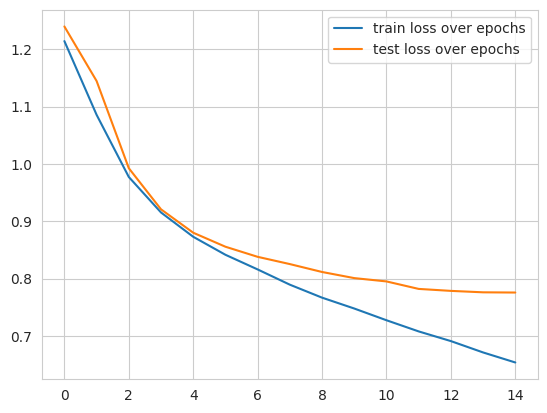

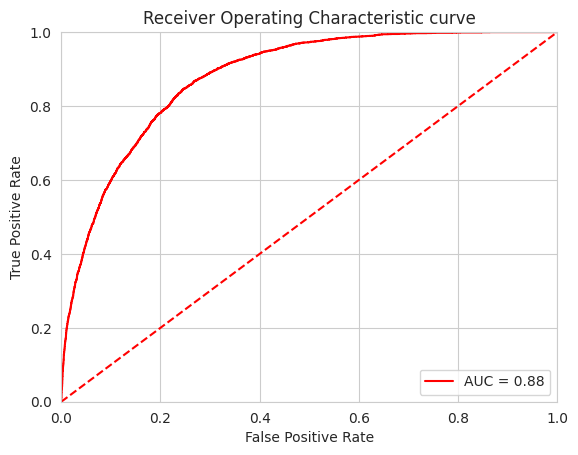

THRESHOLD: 0.1 | F1: 0.5867 | MCC: 0.3502 | Test acc: 55.01%
THRESHOLD: 0.2 | F1: 0.6780 | MCC: 0.4088 | Test acc: 64.08%
THRESHOLD: 0.3 | F1: 0.7360 | MCC: 0.4510 | Test acc: 70.40%
THRESHOLD: 0.4 | F1: 0.7775 | MCC: 0.4797 | Test acc: 75.21%
THRESHOLD: 0.5 | F1: 0.8043 | MCC: 0.4881 | Test acc: 78.55%
THRESHOLD: 0.6 | F1: 0.8265 | MCC: 0.4937 | Test acc: 81.54%
THRESHOLD: 0.7 | F1: 0.8421 | MCC: 0.4951 | Test acc: 83.97%
THRESHOLD: 0.8 | F1: 0.8418 | MCC: 0.4681 | Test acc: 85.08%
THRESHOLD: 0.9 | F1: 0.8157 | MCC: 0.3925 | Test acc: 84.52%


In [37]:
model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(), lr=0.0001)

fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=15, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

import os
os.makedirs(f'{DATA_PATH}/model', exist_ok=True)

# save the constructed model (state_dict)
torch.save(model_3.state_dict(), f'{DATA_PATH}/model/cryptobench_classifier.pt')
# save the entire model
torch.save(model_3, f'{DATA_PATH}/model/cryptobench_classifier_model.pt')